# Gestión Moderna de Portafolio
### Autores Bernardo León y Carlos Zapata
### (C) Copyright 2023


## Capitulo 16: Criterios ASG y portafolio óptimo

In [1]:
import requests
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import cvxpy as cp
import urllib.request
import json
%pip install --quiet yfinance
import yfinance as yf
import warnings
warnings.simplefilter("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 872.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.6 MB/s eta 0:00:00


In [ ]:
# Información histórica dentro de muetsra (In-sample) para las acciones
fechai = "2015-12-01"
fechaf = "2020-12-31"
periodicidad = "1Mo"
activos = ["ADBE","MCD","MSCI","MSFT","NEE","PG","RSG","WMT"]
precios = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()
n = len(mu)

[*********************100%***********************]  8 of 8 completed


In [ ]:
# Datos ESG para los activos
tickers = activos
esg_list = []
e_list = []
s_list = []
g_list = []
missing = []

for ticker in tickers:
    try:
        url = "https://query2.finance.yahoo.com/v1/finance/esgChart?symbol={}".format(ticker)
        connection = urllib.request.urlopen(url)
        data_connection = connection.read()
        data_json = json.loads(data_connection)
        formatdata = data_json["esgChart"]["result"][0]["symbolSeries"]
        df_data = pd.DataFrame(formatdata)
        df_data["timestamp"] = pd.to_datetime(df_data["timestamp"], unit="s")
        df_data = df_data.set_index('timestamp')
        df_data = df_data.loc['2020':'2020']
        esg_list.append(df_data['esgScore'])
        e_list.append(df_data['environmentScore'])
        s_list.append(df_data['socialScore'])
        g_list.append(df_data['governanceScore'])
    except:
        missing.append(ticker)
        continue
# If ticker is missing data remove ticker from investment sample universe
if missing != None:
    for tick in missing:
        tickers.remove(tick)
esg_df = pd.concat(esg_list, axis=1).dropna()
esg_df.columns = tickers
e_df = pd.concat(e_list, axis=1)
e_df.columns = tickers
s_df = pd.concat(s_list, axis=1)
s_df.columns = tickers
g_df = pd.concat(g_list, axis=1)
g_df.columns = tickers

In [ ]:
# Se filtra el indicador ESG para el último mes de historia
t = len(esg_df)
esg_score = np.array(esg_df.iloc[-1,:])
esg_score

array([13.32, 23.97, 23.17, 14.94, 29.45, 24.68, 23.75, 28.72])

In [ ]:
# Se ajustan los demás inputs como arrays
mui = np.array(mu)
covi = np.array(cov)

## Portfolio MV de Markowitz

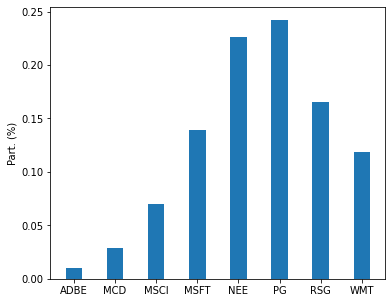

In [ ]:
# PMVG
unos = np.repeat(1,n)
cov_inv_1 = np.linalg.solve(cov,unos) 
wpmvg = (1/(unos @ cov_inv_1)) * cov_inv_1
rpmvg = wpmvg @ mu
sigmapmvg = np.sqrt( wpmvg.T @ cov @ wpmvg)
# Pesos del PMVG
fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpmvg, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [ ]:
# ESG optimization
asgi = esg_score
x = mu.T @ np.linalg.inv(covi) @ mu
y = mu.T @ np.linalg.inv(covi) @ unos
z = unos.T @ np.linalg.inv(covi) @ unos
p = mui.T @ np.linalg.inv(covi) @ asgi
q = unos.T @ np.linalg.inv(covi) @ asgi
r = asgi.T @ np.linalg.inv(covi) @ asgi
d = x*z*r+y*p*q+y*p*q-z*p**2-x*q**2-r*y**2

g = ((p*q)*np.linalg.solve(covi,mui) - (y*r)*np.linalg.solve(covi,mui) + (x*r)*np.linalg.solve(covi,unos) - 
     (p**2)*np.linalg.solve(covi,unos) + (p*y)*np.linalg.solve(covi,asgi) - (x*q)*np.linalg.solve(covi,asgi)) * (1/d)
h = ((r*z)*np.linalg.solve(covi,mui) - (q**2)*np.linalg.solve(covi,mui) + (p*q)*np.linalg.solve(covi,unos) - 
     (y*r)*np.linalg.solve(covi,unos) + (q*y)*np.linalg.solve(covi,asgi) - (p*z)*np.linalg.solve(covi,asgi)) * (1/d)

f = ((y*q)*np.linalg.solve(covi,mui) - (z*p)*np.linalg.solve(covi,mui) + (p*y)*np.linalg.solve(covi,unos) - 
     (q*x)*np.linalg.solve(covi,unos) + (z*x)*np.linalg.solve(covi,asgi) - (y**2)*np.linalg.solve(covi,asgi)) * (1/d)

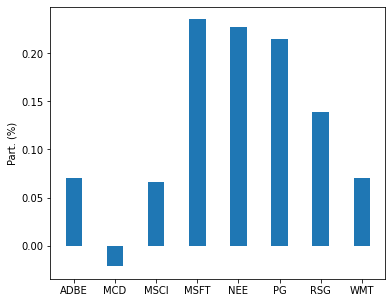

In [ ]:
# Portafolio ASG para un indicador ASG promedio
ip = asgi.mean()
rp = mui.mean()
wpmvESG = g+h*rp+f*ip
fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpmvESG, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

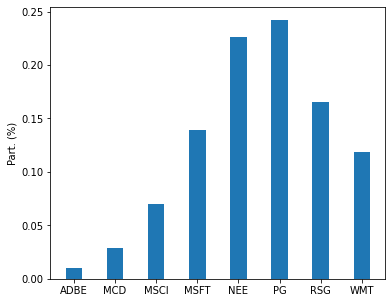

In [ ]:
# Portafolio ASG - Caso Ip=Ip(MVG), Rp=Rp(MVG)
ipMV = wpmvg @ asgi
rpMV = wpmvg @ mu
wpmvESG = g+h*rpMV +f*ipMV
fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpmvESG, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

## Construcción de la FE para un indicador ASG promedio

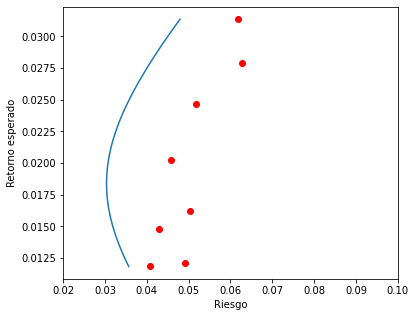

In [ ]:
# Construcción de la FE
rpmin = mu.min()
rpmax = mu.max()
nport = 100
j = np.linspace(rpmin,rpmax, nport) 
wpoESG = np.zeros((nport, n))
rpoESG = np.zeros((nport,1))
sigmapoESG = np.zeros((nport,1))

for i in range(nport):
    wj = g + h*j[i] + f*ip
    wpoESG[i,:] = wj.T
    rpoESG[i] = wj @ mui
    sigmapoESG[i] = np.sqrt( wj.T @ covi @ wj)

# Plano Riesgo-Retorno
fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111)
plt.plot(sigma, mu, "ro")
plt.plot(sigmapoESG, rpoESG)
plt.xlabel("Riesgo")
plt.ylabel("Retorno esperado")
plt.xlim(0.02,0.1)
plt.show()